# 앱 개발자를위한 클릭 사기를 방지 

## 1. Overview
- 사용자의 클릭 경로를 측정하고 많은 클릭을 발생시키는 IP 주소를 신고하며 결코 앱 설치를 중단하지 않음.
- 이 정보로 그들은 IP 블랙리스트와 장치 블랙리스트를 구축.
- 모바일 앱 광고를 클릭 한 후 사용자가 앱을 다운로드할지 여부를 예측하는 알고리즘을 작성
- 예측 된 확률과 데이터 사이의 ROC곡선으로 평가
- 제출파일은 click_id 테스트 세트 각각에 대해 **is_attributed(유저가 앱 다운로드를 했는가) 변수에 대한 확률을 예측**
<br><br>



## 2. Process of Analysis
### 1) EDA 
- 변수들의 타입 지정하기
- 동일한 ip가 클릭한 수에 대해 count 변수 생성 (평균 광고를 1018번 클릭한 뒤 앱을 설치)
- 광고 클릭 수 대비 is_attributed 를 통해 prop_downloaded (다운로드할 가능성)을 확률로 지정
- ip, app, device, channel과 is_attributed 사이의 관련도를 그래프로 시각화


### 2) click-time, attributed_time을 활용한 시간패턴으로 예측하기 
- 시간 패턴 그래프 시각화
- 타임패스 = 클릭한 시간 - 다운로드 받은 시간 하여 열추가
- 타임패스가 4초 이하, 20시간 이상일 경우 이상 ip로 추정 

### 3) deep-learning으로 is_attributed 예측하기

In [16]:
import pandas as pd
import numpy as np
import datetime
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## seaborn라이브러리로 미리 시각화 그래프 크기 지정하기

In [3]:
sns.set(rc={'figure.figsize' :(12,5)})
plt.figure(figsize=(12,5))

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

## 데이터 셋의 크기 
- test : 863.2 mb
- train : 7357.6 mb

In [5]:
print('#File sizes')
for f in os.listdir('../input/'):
    print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

#File sizes
sample_submission.csv         195.58MB
test.csv                      863.27MB
test_supplement.csv           2665.54MB
train.csv                     7537.65MB
train_sample.csv              4.08MB


### train 데이터 셋 크기가 커서 nrows를 지정하여 불러오기. (지정하지 않을 경우 메모리부족으로 올라오지 않음)

In [6]:
train = pd.read_csv('../input/train.csv', skiprows = range(1, 131886954))
test = pd.read_csv('../input/test.csv')

In [7]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,201143,11,1,13,487,2017-11-09 00:00:00,NaN,0
1,34684,2,1,13,469,2017-11-09 00:00:00,NaN,0
2,207368,26,1,19,477,2017-11-09 00:00:00,NaN,0
3,110176,18,1,8,121,2017-11-09 00:00:00,NaN,0
4,109644,12,1,19,265,2017-11-09 00:00:00,NaN,0


In [8]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


### test, train 셋에 있는 컬럼 타입을 **'카테고리'**로 변경 
time은 pandas로 time형태로 바꿈

In [9]:
col = ['ip', 'app', 'device', 'os', 'channel']
for c in col:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

In [10]:
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

train['is_attributed'] = train['is_attributed'].astype('category')

In [11]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,53016937.0,53016937.0,53016937.0,53016937.0,53016937.0,53016937,133967,53016937.0
unique,110963.0,486.0,2359.0,479.0,187.0,57601,50743,2.0
top,5348.0,3.0,1.0,19.0,280.0,2017-11-09 12:00:11,2017-11-09 14:46:53,0.0
freq,374392.0,9340315.0,49891688.0,12537977.0,3918534.0,1471,13,52882970.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-09 00:00:00,2017-11-09 00:00:54,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 16:00:00,NaN


### 변수들의 유니크 값 

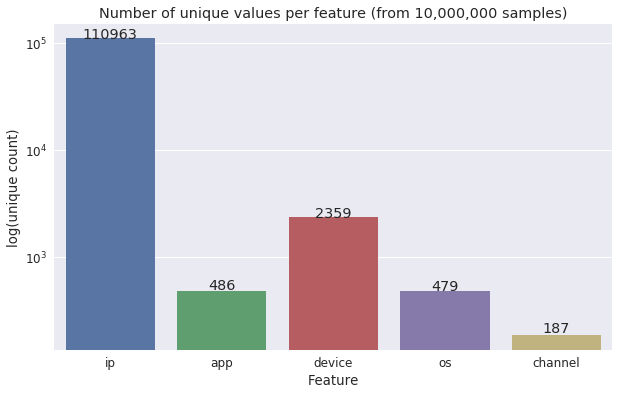

In [12]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

In [13]:
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,133967,133967.0
unique,50743,1.0
top,2017-11-09 14:46:53,1.0
freq,13,133967.0
first,2017-11-09 00:00:54,NaN
last,2017-11-09 16:00:00,NaN


In [14]:
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


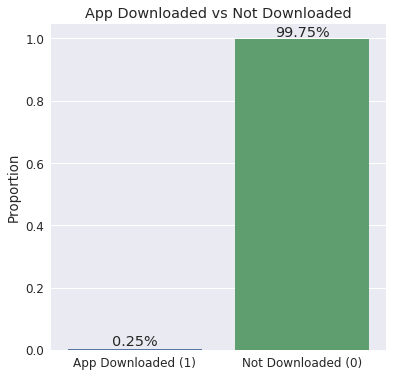

In [15]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [17]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:30]

,ip,counts
0,5348,374392
1,5314,337427
2,73516,196307
3,73487,194498
4,53454,141914
5,17149,130043
6,26995,121791
7,114276,118756
8,112302,114715
9,95766,113979


In [18]:
train= train.merge(temp, on='ip', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [19]:
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:100]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
21496747,5348,72,1,25,101,2017-11-09 06:16:11,2017-11-09 12:24:16,1,374392
30613771,5348,83,0,24,171,2017-11-09 09:10:49,2017-11-09 09:14:38,1,374392
43659457,5348,19,0,38,347,2017-11-09 13:09:50,2017-11-09 13:09:56,1,374392
8926018,5348,19,0,38,343,2017-11-09 02:49:23,2017-11-09 02:49:28,1,374392
43653228,5348,29,1,19,343,2017-11-09 13:09:43,2017-11-09 13:09:59,1,374392
36014588,5348,25,1,19,259,2017-11-09 10:53:36,2017-11-09 10:55:03,1,374392
43620718,5348,20,1,19,259,2017-11-09 13:09:07,2017-11-09 13:10:38,1,374392
26951716,5348,29,1,19,343,2017-11-09 07:53:03,2017-11-09 07:54:36,1,374392
36029178,5348,10,1,14,377,2017-11-09 10:53:51,2017-11-09 11:02:20,1,374392
43594320,5348,29,2,35,343,2017-11-09 13:08:41,2017-11-09 15:59:51,1,374392


In [20]:
train[train['is_attributed']==1].ip.describe()

count     133967
unique     89287
top         5348
freq         651
Name: ip, dtype: int64

In [21]:
train[train['is_attributed']==1].describe()

,counts
count,133967.000000
mean,6956.858935
std,38007.805244
min,1.000000
25%,5.000000
50%,75.000000
75%,1495.000000
max,374392.000000


In [22]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
0,201143,11,1,13,487,2017-11-09,NaT,0,973
1,34684,2,1,13,469,2017-11-09,NaT,0,836
2,207368,26,1,19,477,2017-11-09,NaT,0,1079
3,110176,18,1,8,121,2017-11-09,NaT,0,1864
4,109644,12,1,19,265,2017-11-09,NaT,0,8677


In [23]:
train['is_attributed'] = train['is_attributed'].astype(int)

In [24]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

merge.head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,ip,click_count,prop_downloaded
0,5348,374392,0.001739
1,5314,337427,0.001811
2,73516,196307,0.001513
3,73487,194498,0.001445
4,53454,141914,0.000296


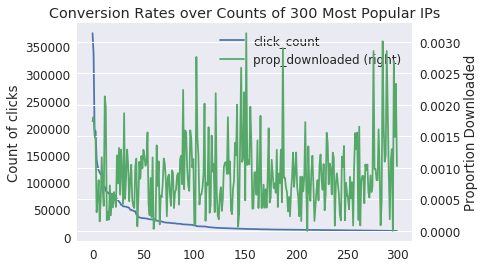

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0     5348       374392         0.001739
1     5314       337427         0.001811
2    73516       196307         0.001513
3    73487       194498         0.001445
4    53454       141914         0.000296
5    17149       130043         0.000531
6    26995       121791         0.000805
7   114276       118756         0.000152
8   112302       114715         0.000471
9    95766       113979         0.001167
10  105475       101657         0.000659
11  111025        92969         0.000398
12    5178        91872         0.002133
13    5147        84756         0.001970
14   48282        82379         0.000170
15   48212        81356         0.000307
16   48240        79486         0.000176
17  123994        77539         0.000722
18   48170        77221         0.000246
19   53964        75814         0.000594


In [25]:
ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


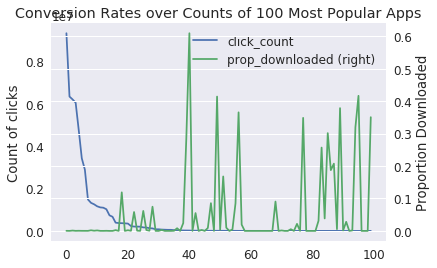

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0    3      9340315         0.000317
1   12      6349572         0.000101
2    9      6213966         0.001098
3    2      6059213         0.000214
4   18      4773490         0.000478
5   15      3432186         0.000266
6   14      2897422         0.000234
7    1      1487137         0.000200
8    8      1327308         0.001937
9    7      1258902         0.000562
10  11      1164213         0.001477
11  13      1112673         0.000171
12  21      1098062         0.000132
13  26      1025214         0.000371
14  23       739222         0.000016
15   6       669183         0.000048
16  20       390610         0.002396
17  25       372051         0.000067
18  19       366716         0.118942
19  28       358705         0.000061


In [26]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


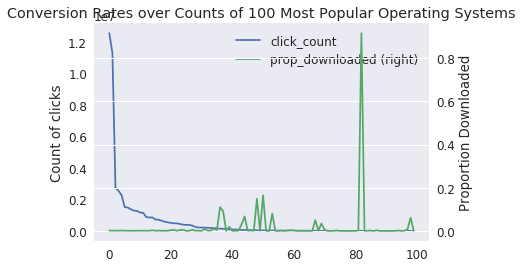

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19     12537977         0.001706
1   13     11284964         0.001442
2   17      2733373         0.001045
3   18      2545110         0.001277
4   22      2259563         0.001651
5    8      1511197         0.001014
6   10      1484640         0.001142
7    6      1371776         0.000880
8    9      1288949         0.000685
9   15      1266642         0.000962
10  25      1166922         0.001056
11  20      1147583         0.001174
12  16       877093         0.001180
13   3       856404         0.000720
14  37       852907         0.003060
15  41       726307         0.000724
16  14       710472         0.001370
17   1       649990         0.000743
18  12       586656         0.000639
19  23       544517         0.000674


In [27]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

In [28]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Count of clicks and proportion of downloads by device:
     device  click_count  prop_downloaded
0         1     49891688         0.001704
1         2      2486647         0.000288
2         0       384918         0.088216
3      3866       148739         0.000013
4         5        14379         0.000000
5        59         6557         0.000915
6         6         4115         0.219198
7        40         3909         0.201330
8        16         3384         0.212766
9        18         2092         0.219407
10       21         1764         0.209751
11       33         1607         0.189172
12       30         1364         0.172287
13     3867         1230         0.175610
14       67         1223         0.205233
15      114         1209         0.183623
16      154         1203         0.162926
17       37         1098         0.198543
18       88         1052         0.230038
19       46         1031         0.137730
20      109          971         0.187436
21        7          

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


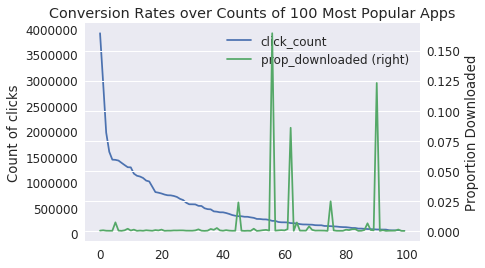

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      280      3918534         0.000283
1      107      2954839         0.000564
2      477      1973977         0.000193
3      265      1598648         0.000144
4      153      1445246         0.000150
5      101      1441246         0.007131
6      259      1427126         0.000304
7      178      1382461         0.000105
8      134      1339084         0.000553
9      145      1297429         0.001837
10     121      1294239         0.000369
11     466      1171913         0.001079
12     205      1130106         0.000105
13     379      1114759         0.000327
14     245      1086488         0.000138
15     232      1035343         0.000566
16     442      1018492         0.000344
17     237       914516         0.000156
18     489       810699         0.000713
19     439       798433         0.000431


In [29]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

# 이상  ip감지 - 시간패턴으로

In [30]:
train_smp = pd.read_csv('../input/train_sample.csv')

In [31]:
train_smp.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0


In [32]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

In [33]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

train_smp[train_smp['is_attributed']==1]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00


Text(0,0.5,'Number of Clicks')

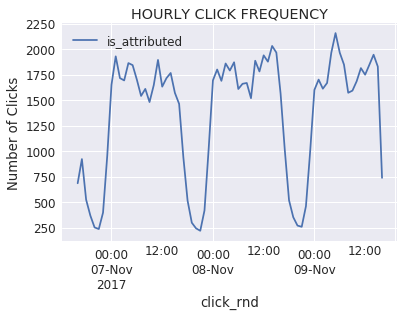

In [34]:
#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd']).count().plot()
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')

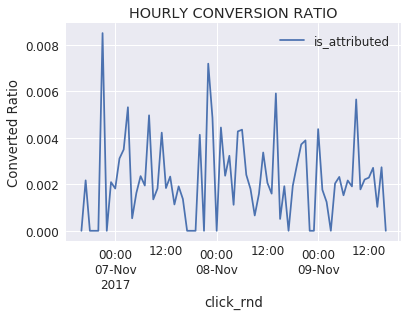

In [35]:
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [36]:
train_smp['click_hour']=train_smp['click_time'].dt.hour
train_smp.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9
5,93663,3,1,17,115,2017-11-09 01:22:13,NaT,0,2017-11-09 01:00:00,1
6,17059,1,1,17,135,2017-11-09 01:17:58,NaT,0,2017-11-09 01:00:00,1


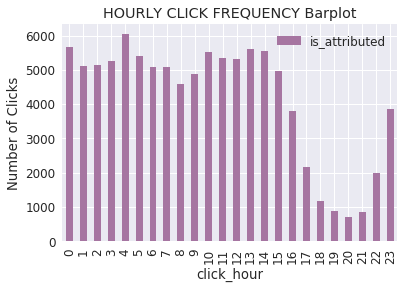

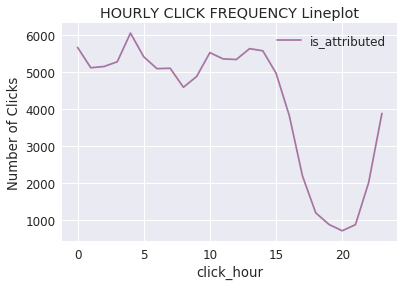

In [37]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

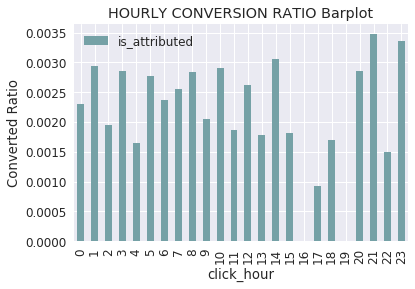

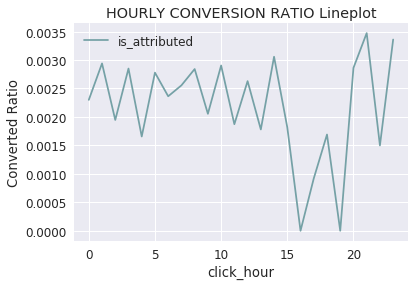

In [38]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

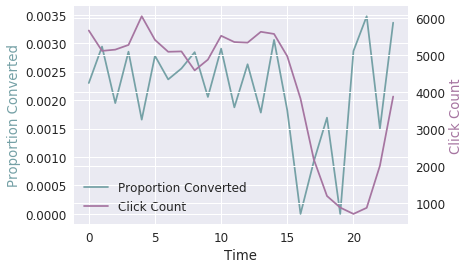

In [39]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

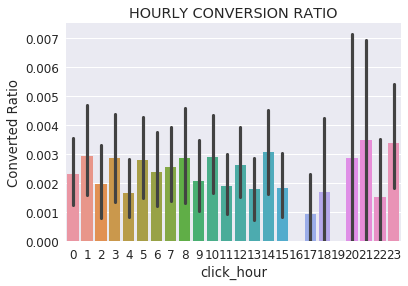

In [40]:
sns.barplot('click_hour', 'is_attributed', data=train_smp)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [41]:
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']
#check:
train_smp[train_smp['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,timePass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,01:39:29


In [42]:
train_smp['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

# Deep

In [43]:
import os
os.environ['OMP_NUM_THREADS'] = '8'
import gc

## train데이터 정의 및 로드

In [44]:
path = '../input/'
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
#9일치 로드
train_df = pd.read_csv(path+"train.csv", dtype=dtypes, skiprows = range(1, 131886954),
                       usecols=['ip','app','device','os', 'channel', 'click_time',
                                'is_attributed'], parse_dates=['click_time'])
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,201143,11,1,13,487,2017-11-09,0
1,34684,2,1,13,469,2017-11-09,0
2,207368,26,1,19,477,2017-11-09,0
3,110176,18,1,8,121,2017-11-09,0
4,109644,12,1,19,265,2017-11-09,0


## test데이터 로드 후 결합

In [45]:
test_df = pd.read_csv(path+"test.csv", dtype=dtypes,
                      usecols=['ip','app','device','os', 'channel', 'click_time',
                               'click_id'],
                      parse_dates=['click_time'])
len_train = len(train_df)
train_df=train_df.append(test_df)
del test_df; gc.collect()
train_df.tail()

,app,channel,click_id,click_time,device,ip,is_attributed,os
18790464,9,127,18790464.0,2017-11-10 15:00:00,1,99442,NaN,13
18790465,23,153,18790465.0,2017-11-10 15:00:00,1,88046,NaN,37
18790466,18,265,18790467.0,2017-11-10 15:00:00,1,81398,NaN,17
18790467,27,122,18790466.0,2017-11-10 15:00:00,1,123236,NaN,13
18790468,12,265,18790468.0,2017-11-10 15:00:00,2,73516,NaN,27


In [46]:
len_train

53016937

## 같은 그룹별 다음 클릭까지의 시간열 추가

In [47]:
train_df['click_time'] = (train_df['click_time'].astype(np.int64) // 10 ** 9).astype(np.int32)
train_df['next_click'] = (train_df.groupby(['ip', 'app', 'device', 'os']).click_time.shift(-1) - train_df.click_time).astype(np.float32)
train_df['next_click'].fillna((train_df['next_click'].mean()), inplace=True)
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click
0,11,487,NaN,1510185600,1,201143,0.0,13,646.0
1,2,469,NaN,1510185600,1,34684,0.0,13,32822.0
2,26,477,NaN,1510185600,1,207368,0.0,19,2175.0
3,18,121,NaN,1510185600,1,110176,0.0,8,2285.0
4,12,265,NaN,1510185600,1,109644,0.0,19,391.0


## 시간, 일, 주 열 추가

In [48]:
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df['wday']  = pd.to_datetime(train_df.click_time).dt.dayofweek.astype('uint8')
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click,hour,day,wday
0,11,487,NaN,1510185600,1,201143,0.0,13,646.0,0,1,3
1,2,469,NaN,1510185600,1,34684,0.0,13,32822.0,0,1,3
2,26,477,NaN,1510185600,1,207368,0.0,19,2175.0,0,1,3
3,18,121,NaN,1510185600,1,110176,0.0,8,2285.0,0,1,3
4,12,265,NaN,1510185600,1,109644,0.0,19,391.0,0,1,3


## 아이피, 일, 시간 그룹화

In [49]:
gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')
del gp; gc.collect()
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click,hour,day,wday,qty
0,11,487,NaN,1510185600,1,201143,0.0,13,646.0,0,1,3,973
1,2,469,NaN,1510185600,1,34684,0.0,13,32822.0,0,1,3,1115
2,26,477,NaN,1510185600,1,207368,0.0,19,2175.0,0,1,3,1079
3,18,121,NaN,1510185600,1,110176,0.0,8,2285.0,0,1,3,2211
4,12,265,NaN,1510185600,1,109644,0.0,19,391.0,0,1,3,11980


## 아이피, 앱 그룹화

In [50]:
gp = train_df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(gp, on=['ip','app'], how='left')
del gp; gc.collect()
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click,hour,day,wday,qty,ip_app_count
0,11,487,NaN,1510185600,1,201143,0.0,13,646.0,0,1,3,973,56
1,2,469,NaN,1510185600,1,34684,0.0,13,32822.0,0,1,3,1115,68
2,26,477,NaN,1510185600,1,207368,0.0,19,2175.0,0,1,3,1079,27
3,18,121,NaN,1510185600,1,110176,0.0,8,2285.0,0,1,3,2211,214
4,12,265,NaN,1510185600,1,109644,0.0,19,391.0,0,1,3,11980,1423


## 아이피, 앱, os 그룹화

In [51]:
gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')
del gp; gc.collect()
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click,hour,day,wday,qty,ip_app_count,ip_app_os_count
0,11,487,NaN,1510185600,1,201143,0.0,13,646.0,0,1,3,973,56,13
1,2,469,NaN,1510185600,1,34684,0.0,13,32822.0,0,1,3,1115,68,8
2,26,477,NaN,1510185600,1,207368,0.0,19,2175.0,0,1,3,1079,27,13
3,18,121,NaN,1510185600,1,110176,0.0,8,2285.0,0,1,3,2211,214,10
4,12,265,NaN,1510185600,1,109644,0.0,19,391.0,0,1,3,11980,1423,351


## 추가한 데이터 타입 변환

In [52]:
train_df['qty'] = train_df['qty'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

## 라벨 인코딩

In [53]:
from sklearn.preprocessing import LabelEncoder
train_df[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click,hour,day,wday,qty,ip_app_count,ip_app_os_count
0,11,487,NaN,1510185600,1,201143,0.0,13,646.0,0,1,3,973,56,13
1,2,469,NaN,1510185600,1,34684,0.0,13,32822.0,0,1,3,1115,68,8
2,26,477,NaN,1510185600,1,207368,0.0,19,2175.0,0,1,3,1079,27,13
3,18,121,NaN,1510185600,1,110176,0.0,8,2285.0,0,1,3,2211,214,10
4,12,265,NaN,1510185600,1,109644,0.0,19,391.0,0,1,3,11980,1423,351


## train, test 길이 조정 및 찾을 값(y_train) 생성

In [54]:
test_df = train_df[len_train:]
train_df = train_df[:len_train]
y_train = train_df['is_attributed']
test_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,next_click,hour,day,wday,qty,ip_app_count,ip_app_os_count
53016937,9,107,0.0,1510286400,1,5744,NaN,3,5838.40918,0,1,3,469,87,3
53016938,9,466,1.0,1510286400,1,119901,NaN,3,399.00000,0,1,3,7918,1089,14
53016939,21,128,2.0,1510286400,1,72287,NaN,19,88.00000,0,1,3,5719,417,52
53016940,15,111,3.0,1510286400,1,78477,NaN,13,425.00000,0,1,3,4513,193,45
53016941,12,328,4.0,1510286400,1,123080,NaN,13,1208.00000,0,1,3,583,79,27


In [55]:
train_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)
train_df.head()

,app,channel,device,os,next_click,hour,day,wday,qty,ip_app_count,ip_app_os_count
0,11,487,1,13,646.0,0,1,3,973,56,13
1,2,469,1,13,32822.0,0,1,3,1115,68,8
2,26,477,1,19,2175.0,0,1,3,1079,27,13
3,18,121,1,8,2285.0,0,1,3,2211,214,10
4,12,265,1,19,391.0,0,1,3,11980,1423,351


## 딥러닝 전에 단순히 모든 is_attributed가 0이라고 했을 때 정확도

In [56]:
print(str((1 -  len(y_train[y_train==1])/ len(y_train))  * 100) + '%')

99.74731282571078%


## Keras를 통한 다층퍼셉트론 모델 적용

In [57]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [60]:
# def get_keras_data(dataset):
#     np_data = np.array(np.rec.fromrecords(dataset.values))
#     np_names = dataset.dtypes.index.tolist()
#     np_data.dtype.names = tuple(dataset.columns)
#     return np_data
# train_df_np = get_keras_data(train_df)
#train_df_np

In [61]:
model = Sequential()
model.add(Dense(16, input_dim=11, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [62]:
model.fit(train_df, y_train, batch_size=50000, epochs=2)
del train_df, y_train; gc.collect()

Epoch 1/2
53016937/53016937 [==============================] - 40s 1us/step - loss: 0.1996 - acc: 0.9872
Epoch 2/2
53016937/53016937 [==============================] - 39s 1us/step - loss: 0.0407 - acc: 0.9975


6460

In [63]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
test_df.drop(['click_id', 'click_time','ip','is_attributed'],1,inplace=True)
# test_df_np = get_keras_data(test_df)

## 값 예측하기

In [64]:
sub['is_attributed'] = model.predict(test_df)
del test_df; gc.collect()
sub.head()

,click_id,is_attributed
53016937,0,0.0
53016938,1,0.0
53016939,2,0.0
53016940,3,0.0
53016941,4,0.0


## csv 저장

In [ ]:
sub.to_csv('imbalanced_data.csv',index=False)